# **1. Data Processing**

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
from pandas import read_csv
from datetime import datetime
dataraw= read_csv('Econ_predictors_2020-08.csv')
dataraw.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,1/1/1959,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6250,23.4581,22.1904,32.4078,...,11.358,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2043,NaN
1,2/1/1959,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0681,23.7747,22.3827,32.6455,...,11.375,2.14,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5280,NaN
2,3/1/1959,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4004,23.9186,22.4925,32.6455,...,11.395,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6405,NaN
3,4/1/1959,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8989,24.2641,22.8221,33.1606,...,11.436,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8099,NaN
4,5/1/1959,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2589,24.4655,23.0418,33.3190,...,11.454,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7315,NaN


In [3]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('Econ_predictors_2020-08.csv')
# manually select columns
dataset = dataset[['sasdate','UNRATE','CUMFNS','BAAFFM','CLAIMSx','HWIURATIO','UEMPLT5','UEMP5TO14','UEMP15OV','UEMP15T26','UEMP27OV','CES1021000001']]
# manually specify column names
dataset.columns = ['sasdate','Unemployment', 'CapacityUtili_Manufactur', 'HousingPermit_MW', 'HousingStarts', 'Nonrevolving_ConsumerCredit', 'AaaCorporateBond_MinusFEDFUNDS', 'AaaCorporateBond', 'ConsumerSentimentIndex','unknown1','unknown2','unkown3']
dataset.set_index('sasdate', inplace=True)
# mark all NA values with 0
#dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
#dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('clean_econ_predictors.csv')

          Unemployment  CapacityUtili_Manufactur  HousingPermit_MW  \
sasdate                                                              
1/1/1959           6.0                   80.1973              2.39   
2/1/1959           5.9                   81.4428              2.46   
3/1/1959           5.6                   82.4769              2.05   
4/1/1959           5.2                   83.9922              1.90   
5/1/1959           5.1                   84.9159              2.06   

          HousingStarts  Nonrevolving_ConsumerCredit  \
sasdate                                                
1/1/1959         291078                     0.333579   
2/1/1959         282958                     0.358386   
3/1/1959         260346                     0.400947   
4/1/1959         246413                     0.444973   
5/1/1959         246952                     0.475711   

          AaaCorporateBond_MinusFEDFUNDS  AaaCorporateBond  \
sasdate                                               

# **2. Single Step Prediction**

In [4]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [5]:
# load dataset
dataset = read_csv('clean_econ_predictors2.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning

n_months = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
reframed.head(5)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[34,35,36,37,38,39,40,41,42,43]], axis=1, inplace=True)
reframed.head(5)

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var1(t)
3,0.230089,0.639453,0.500389,0.023605,0.151967,0.011127,0.036438,0.120237,0.064039,0.102767,...,0.473971,0.017287,0.241520,0.002179,0.031071,0.099079,0.053869,0.084518,0.303356,0.159292
4,0.221239,0.678704,0.505828,0.021936,0.191316,0.009570,0.036085,0.106700,0.056253,0.092296,...,0.462315,0.014422,0.310719,0.004902,0.019843,0.079627,0.034483,0.077188,0.304975,0.150442
5,0.194690,0.711293,0.473971,0.017287,0.241520,0.002179,0.031071,0.099079,0.053869,0.084518,...,0.474748,0.014533,0.356852,0.003735,0.024857,0.071209,0.031622,0.068811,0.312040,0.141593
6,0.159292,0.759048,0.462315,0.014422,0.310719,0.004902,0.019843,0.079627,0.034483,0.077188,...,0.442890,0.016858,0.408412,0.007081,0.021891,0.070982,0.035595,0.064772,0.319399,0.150442
7,0.150442,0.788158,0.474748,0.014533,0.356852,0.003735,0.024857,0.071209,0.031622,0.068811,...,0.439782,0.017883,0.385346,0.012449,0.027823,0.062564,0.032258,0.056844,0.334560,0.159292


In [ ]:
reframed.shape

(736, 34)

# **2.1 Three month moving window size (year 2020 included)**




In [14]:
# split into train and test sets
#I splitted by 0.5
values = reframed.values
n_train_months = 255
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(255, 1, 33) (255,) (481, 1, 33) (481,)


Epoch 1/400
2/2 - 3s - loss: 0.1886 - val_loss: 0.2345
Epoch 2/400
2/2 - 0s - loss: 0.1754 - val_loss: 0.2217
Epoch 3/400
2/2 - 0s - loss: 0.1666 - val_loss: 0.2091
Epoch 4/400
2/2 - 0s - loss: 0.1572 - val_loss: 0.1968
Epoch 5/400
2/2 - 0s - loss: 0.1458 - val_loss: 0.1849
Epoch 6/400
2/2 - 0s - loss: 0.1415 - val_loss: 0.1735
Epoch 7/400
2/2 - 0s - loss: 0.1343 - val_loss: 0.1624
Epoch 8/400
2/2 - 0s - loss: 0.1267 - val_loss: 0.1520
Epoch 9/400
2/2 - 0s - loss: 0.1158 - val_loss: 0.1422
Epoch 10/400
2/2 - 0s - loss: 0.1165 - val_loss: 0.1337
Epoch 11/400
2/2 - 0s - loss: 0.1143 - val_loss: 0.1261
Epoch 12/400
2/2 - 0s - loss: 0.1116 - val_loss: 0.1195
Epoch 13/400
2/2 - 0s - loss: 0.1040 - val_loss: 0.1138
Epoch 14/400
2/2 - 0s - loss: 0.1002 - val_loss: 0.1090
Epoch 15/400
2/2 - 0s - loss: 0.1025 - val_loss: 0.1053
Epoch 16/400
2/2 - 0s - loss: 0.1030 - val_loss: 0.1023
Epoch 17/400
2/2 - 0s - loss: 0.0977 - val_loss: 0.0998
Epoch 18/400
2/2 - 0s - loss: 0.1047 - val_loss: 0.0978
E

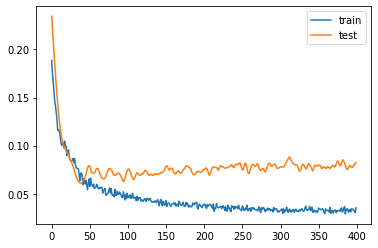

In [15]:
# design network
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional

model = Sequential()
model.add((LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences = True)))
model.add(Dropout(0.6))
model.add(LSTM(16))
model.add(Dropout(0.6))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=400, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [16]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*11))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -10:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -10:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate MSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)



Test MSE: 1.207


hyperparameter tuning that seems to achieve the best result:
LSTM with 16 units, epoch 400, batch size 72

In [17]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 0.930


# **2.2 Three month moving window size (year 2020 excluded) **


In [10]:
# split into train and test sets
#I splitted by 0.5
values = reframed.values
n_train_months = 255
train = values[:n_train_months, :]
test = values[n_train_months:500, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(255, 1, 33) (255,) (245, 1, 33) (245,)


Epoch 1/400
2/2 - 3s - loss: 0.1780 - val_loss: 0.2431
Epoch 2/400
2/2 - 0s - loss: 0.1695 - val_loss: 0.2315
Epoch 3/400
2/2 - 0s - loss: 0.1610 - val_loss: 0.2201
Epoch 4/400
2/2 - 0s - loss: 0.1525 - val_loss: 0.2085
Epoch 5/400
2/2 - 0s - loss: 0.1440 - val_loss: 0.1974
Epoch 6/400
2/2 - 0s - loss: 0.1423 - val_loss: 0.1866
Epoch 7/400
2/2 - 0s - loss: 0.1334 - val_loss: 0.1762
Epoch 8/400
2/2 - 0s - loss: 0.1309 - val_loss: 0.1662
Epoch 9/400
2/2 - 0s - loss: 0.1189 - val_loss: 0.1565
Epoch 10/400
2/2 - 0s - loss: 0.1167 - val_loss: 0.1472
Epoch 11/400
2/2 - 0s - loss: 0.1160 - val_loss: 0.1381
Epoch 12/400
2/2 - 0s - loss: 0.1118 - val_loss: 0.1295
Epoch 13/400
2/2 - 0s - loss: 0.1081 - val_loss: 0.1216
Epoch 14/400
2/2 - 0s - loss: 0.1082 - val_loss: 0.1148
Epoch 15/400
2/2 - 0s - loss: 0.1030 - val_loss: 0.1093
Epoch 16/400
2/2 - 0s - loss: 0.1053 - val_loss: 0.1050
Epoch 17/400
2/2 - 0s - loss: 0.0962 - val_loss: 0.1012
Epoch 18/400
2/2 - 0s - loss: 0.0901 - val_loss: 0.0982
E

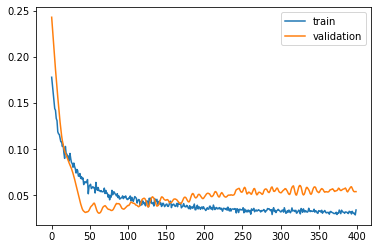

In [11]:
# design network
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional

model = Sequential()
model.add((LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences = True)))
model.add(Dropout(0.6))
model.add(LSTM(16))
model.add(Dropout(0.6))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=400, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [12]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*11))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -10:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -10:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate MSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

Test MSE: 0.489


In [13]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 0.610


We can see that using the exact same architecture, taking out year 2020 from the test data set achieves much better test results (RMSE of 0.263 versus 0.686)


# **2.3 One month moving window size (2020 included)**

In [56]:
# load dataset
dataset = read_csv('clean_econ_predictors1.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head(5)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#print(reframed.head())

In [57]:
# split into train and test sets
#I splitted by 0.5
values = reframed.values
n_train_months = 255
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(255, 1, 8) (255,) (255, 1, 8) (255,)


Epoch 1/400
4/4 - 2s - loss: 0.2346 - val_loss: 0.1592
Epoch 2/400
4/4 - 0s - loss: 0.1952 - val_loss: 0.1445
Epoch 3/400
4/4 - 0s - loss: 0.1608 - val_loss: 0.1424
Epoch 4/400
4/4 - 0s - loss: 0.1320 - val_loss: 0.1484
Epoch 5/400
4/4 - 0s - loss: 0.1149 - val_loss: 0.1579
Epoch 6/400
4/4 - 0s - loss: 0.1070 - val_loss: 0.1648
Epoch 7/400
4/4 - 0s - loss: 0.1036 - val_loss: 0.1683
Epoch 8/400
4/4 - 0s - loss: 0.1018 - val_loss: 0.1687
Epoch 9/400
4/4 - 0s - loss: 0.0999 - val_loss: 0.1667
Epoch 10/400
4/4 - 0s - loss: 0.0979 - val_loss: 0.1632
Epoch 11/400
4/4 - 0s - loss: 0.0958 - val_loss: 0.1590
Epoch 12/400
4/4 - 0s - loss: 0.0942 - val_loss: 0.1549
Epoch 13/400
4/4 - 0s - loss: 0.0928 - val_loss: 0.1510
Epoch 14/400
4/4 - 0s - loss: 0.0915 - val_loss: 0.1476
Epoch 15/400
4/4 - 0s - loss: 0.0904 - val_loss: 0.1450
Epoch 16/400
4/4 - 0s - loss: 0.0890 - val_loss: 0.1432
Epoch 17/400
4/4 - 0s - loss: 0.0873 - val_loss: 0.1420
Epoch 18/400
4/4 - 0s - loss: 0.0854 - val_loss: 0.1412
E

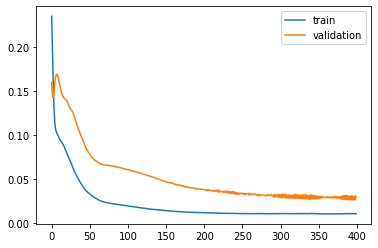

In [58]:
# design network
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional

model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
#model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [59]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

Test MSE: 0.496


In [60]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 0.341


# **2.4 One month moving window size (2020 excluded)**

In [67]:
# split into train and test sets
#I splitted by 0.5
values = reframed.values
n_train_months = 255
train = values[:n_train_months, :]
test = values[n_train_months:500, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(255, 1, 8) (255,) (245, 1, 8) (245,)


Epoch 1/400
4/4 - 2s - loss: 0.2732 - val_loss: 0.1855
Epoch 2/400
4/4 - 0s - loss: 0.2275 - val_loss: 0.1621
Epoch 3/400
4/4 - 0s - loss: 0.1890 - val_loss: 0.1511
Epoch 4/400
4/4 - 0s - loss: 0.1557 - val_loss: 0.1518
Epoch 5/400
4/4 - 0s - loss: 0.1342 - val_loss: 0.1575
Epoch 6/400
4/4 - 0s - loss: 0.1232 - val_loss: 0.1644
Epoch 7/400
4/4 - 0s - loss: 0.1187 - val_loss: 0.1690
Epoch 8/400
4/4 - 0s - loss: 0.1164 - val_loss: 0.1705
Epoch 9/400
4/4 - 0s - loss: 0.1145 - val_loss: 0.1692
Epoch 10/400
4/4 - 0s - loss: 0.1126 - val_loss: 0.1660
Epoch 11/400
4/4 - 0s - loss: 0.1108 - val_loss: 0.1620
Epoch 12/400
4/4 - 0s - loss: 0.1093 - val_loss: 0.1578
Epoch 13/400
4/4 - 0s - loss: 0.1079 - val_loss: 0.1538
Epoch 14/400
4/4 - 0s - loss: 0.1067 - val_loss: 0.1502
Epoch 15/400
4/4 - 0s - loss: 0.1056 - val_loss: 0.1471
Epoch 16/400
4/4 - 0s - loss: 0.1045 - val_loss: 0.1445
Epoch 17/400
4/4 - 0s - loss: 0.1034 - val_loss: 0.1424
Epoch 18/400
4/4 - 0s - loss: 0.1020 - val_loss: 0.1406
E

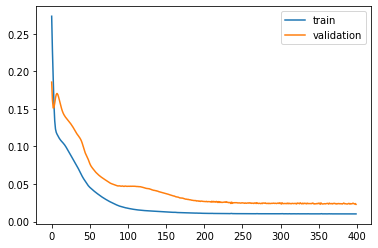

In [68]:
# design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dropout(0.6))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [69]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

Test MSE: 0.092


In [70]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 0.258


# **3. Multi step forecast**

In [ ]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [ ]:
# load dataset
dataset = read_csv('clean_econ_predictors1.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_months = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_months, 1)
print(reframed.shape)


(508, 32)


# **3.1 Test Set with year 2020**



In [ ]:
# split into train and test sets
values = reframed.values
n_train_months = 255
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(255, 24) 255 (255,)
(255, 3, 8) (255,) (253, 3, 8) (253,)


Epoch 1/400
4/4 - 0s - loss: 0.5992 - val_loss: 0.5015
Epoch 2/400
4/4 - 0s - loss: 0.5143 - val_loss: 0.4208
Epoch 3/400
4/4 - 0s - loss: 0.4313 - val_loss: 0.3411
Epoch 4/400
4/4 - 0s - loss: 0.3497 - val_loss: 0.2623
Epoch 5/400
4/4 - 0s - loss: 0.2689 - val_loss: 0.1844
Epoch 6/400
4/4 - 0s - loss: 0.1914 - val_loss: 0.1302
Epoch 7/400
4/4 - 0s - loss: 0.1300 - val_loss: 0.1187
Epoch 8/400
4/4 - 0s - loss: 0.0928 - val_loss: 0.1365
Epoch 9/400
4/4 - 0s - loss: 0.0807 - val_loss: 0.1509
Epoch 10/400
4/4 - 0s - loss: 0.0829 - val_loss: 0.1530
Epoch 11/400
4/4 - 0s - loss: 0.0789 - val_loss: 0.1442
Epoch 12/400
4/4 - 0s - loss: 0.0690 - val_loss: 0.1315
Epoch 13/400
4/4 - 0s - loss: 0.0641 - val_loss: 0.1205
Epoch 14/400
4/4 - 0s - loss: 0.0639 - val_loss: 0.1128
Epoch 15/400
4/4 - 0s - loss: 0.0636 - val_loss: 0.1078
Epoch 16/400
4/4 - 0s - loss: 0.0621 - val_loss: 0.1049
Epoch 17/400
4/4 - 0s - loss: 0.0589 - val_loss: 0.1036
Epoch 18/400
4/4 - 0s - loss: 0.0543 - val_loss: 0.1034
E

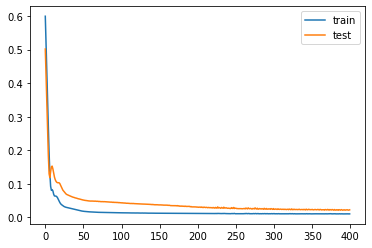

In [ ]:
# design network
model = Sequential()
model.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.776


# **3.2 Test set without year 2020**

In [ ]:
# split into train and test sets
values = reframed.values
n_train_months = 255
train = values[:n_train_months, :]
test = values[n_train_months:500, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(255, 24) 255 (255,)
(255, 3, 8) (255,) (245, 3, 8) (245,)


Epoch 1/400
4/4 - 0s - loss: 0.3376 - val_loss: 0.1601
Epoch 2/400
4/4 - 0s - loss: 0.2636 - val_loss: 0.1091
Epoch 3/400
4/4 - 0s - loss: 0.1921 - val_loss: 0.1033
Epoch 4/400
4/4 - 0s - loss: 0.1339 - val_loss: 0.1333
Epoch 5/400
4/4 - 0s - loss: 0.1007 - val_loss: 0.1569
Epoch 6/400
4/4 - 0s - loss: 0.0980 - val_loss: 0.1688
Epoch 7/400
4/4 - 0s - loss: 0.0976 - val_loss: 0.1701
Epoch 8/400
4/4 - 0s - loss: 0.0948 - val_loss: 0.1641
Epoch 9/400
4/4 - 0s - loss: 0.0903 - val_loss: 0.1544
Epoch 10/400
4/4 - 0s - loss: 0.0863 - val_loss: 0.1433
Epoch 11/400
4/4 - 0s - loss: 0.0834 - val_loss: 0.1325
Epoch 12/400
4/4 - 0s - loss: 0.0824 - val_loss: 0.1237
Epoch 13/400
4/4 - 0s - loss: 0.0826 - val_loss: 0.1188
Epoch 14/400
4/4 - 0s - loss: 0.0820 - val_loss: 0.1180
Epoch 15/400
4/4 - 0s - loss: 0.0792 - val_loss: 0.1193
Epoch 16/400
4/4 - 0s - loss: 0.0757 - val_loss: 0.1208
Epoch 17/400
4/4 - 0s - loss: 0.0727 - val_loss: 0.1211
Epoch 18/400
4/4 - 0s - loss: 0.0700 - val_loss: 0.1200
E

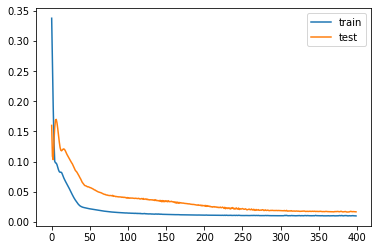

In [ ]:
# design network
model = Sequential()
model.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.245
